In [80]:
from u2net import U2NET
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import time
from skimage import transform
from umap import UMAP

gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
all_images = np.load('data/saved np/all_images_no_preprocess.npy', allow_pickle=True)
all_images_rgb = []
for i, images_list in enumerate(all_images):
    for image_gray in images_list:
        tf_image = tf.expand_dims(image_gray / 255, 2)
    #    tf_rgb = tf.image.grayscale_to_rgb(tf_image)
        tf_preproc = tf.image.resize(tf_image, (1024, 1024))
        all_images_rgb.append(tf_preproc)

all_images_rgb = np.array(all_images_rgb)

In [152]:
image_shape = (1024, 1024, 1)
inputs = tf.keras.Input(shape=image_shape)
net = U2NET(1)
out = net(inputs)
model = tf.keras.Model(inputs=inputs, outputs=out[0], name='u2netmodel')

In [146]:
model.summary()

Model: "u2netmodel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1024, 1024, 1)]   0         
_________________________________________________________________
u2net_2 (U2NET)              ((None, 1024, 1024, 1), ( 44037517  
Total params: 44,037,517
Trainable params: 44,008,717
Non-trainable params: 28,800
_________________________________________________________________


In [151]:
N=100
x_train, x_test, y_train, y_test = train_test_split(  all_images_rgb[:N],all_images_rgb[:N], test_size=0.2 )

In [153]:
model.compile(optimizer='rmsprop', loss='MSE', metrics=['MAE'])
history=model.fit(x_train, y_train,
                        epochs=24,
                        batch_size=1,
                        shuffle=True,
                        validation_data=(x_test, x_test))

Epoch 1/24
80/80 [==============================] - 59s 556ms/step - loss: 0.0728 - MAE: 0.1948 - val_loss: 0.1326 - val_MAE: 0.3355
Epoch 2/24
80/80 [==============================] - 43s 534ms/step - loss: 0.0240 - MAE: 0.1004 - val_loss: 0.1326 - val_MAE: 0.3355
Epoch 3/24
80/80 [==============================] - 43s 533ms/step - loss: 0.0181 - MAE: 0.0869 - val_loss: 0.1220 - val_MAE: 0.3164
Epoch 4/24
80/80 [==============================] - 42s 530ms/step - loss: 0.0092 - MAE: 0.0495 - val_loss: 0.0094 - val_MAE: 0.0595
Epoch 5/24
80/80 [==============================] - 42s 526ms/step - loss: 0.0071 - MAE: 0.0475 - val_loss: 0.1319 - val_MAE: 0.3345
Epoch 6/24
80/80 [==============================] - 42s 526ms/step - loss: 0.0047 - MAE: 0.0355 - val_loss: 0.0061 - val_MAE: 0.0469
Epoch 7/24
80/80 [==============================] - 42s 527ms/step - loss: 0.0034 - MAE: 0.0298 - val_loss: 0.1321 - val_MAE: 0.3345
Epoch 8/24
80/80 [==============================] - 42s 525ms/step - 

In [161]:
model.save_weights('autoencoder.h5')
net.save_weights('u2net.h5')

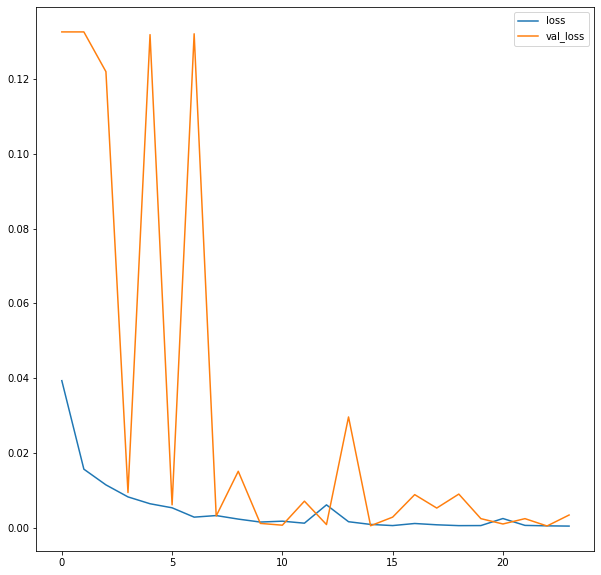

In [154]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()

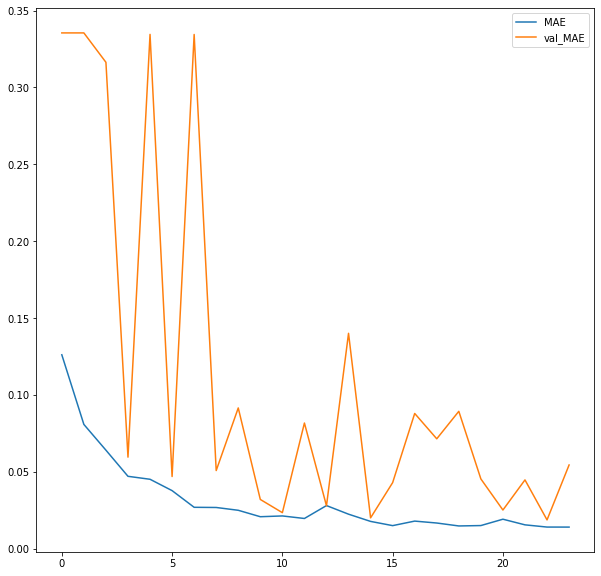

In [155]:
plt.figure(figsize=(10,10))
plt.plot(history.history['MAE'])
plt.plot(history.history['val_MAE'])
plt.legend(['MAE','val_MAE'])
plt.show()

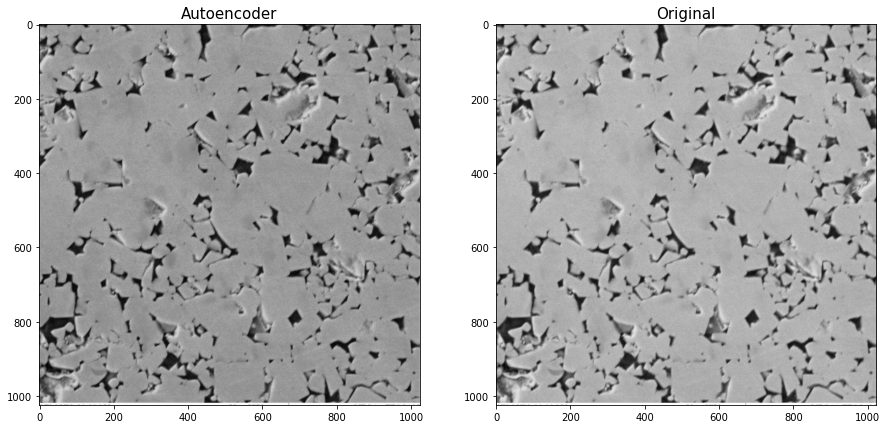

In [156]:
#predict=model.predict(tf.expand_dims(all_images_rgb[0],axis=0))[0]
predict=net(tf.expand_dims(x_test[0],axis=0))[0][0]

original=x_test[0]

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,15))
ax1.imshow(predict,cmap='gray')
ax1.set_title('Autoencoder',fontsize=15)

ax2.imshow(original,cmap='gray')
ax2.set_title('Original',fontsize=15)
plt.savefig('autoencoder_test.png')
plt.show()

In [92]:
net(tf.expand_dims(all_images_rgb[0],axis=0))[1][0].numpy().flatten().shape

(1024,)

In [157]:
all_images = np.load('data/saved np/all_images_no_preprocess.npy', allow_pickle=True)
images_embs = []
for i, images_list in enumerate(all_images):
    for image_gray in images_list:
        resized = transform.resize(image_gray, (1024, 1024,1))
        emb=net(tf.expand_dims(resized,axis=0))[1][0].numpy().flatten()
        images_embs.append(emb)

In [158]:
umap_news=UMAP()
umaped_vct=umap_news.fit_transform(images_embs)

In [159]:
color_indeces=[len(all_images[0]),
               len(all_images[0])+len(all_images[1]),
               len(all_images[0])+len(all_images[1])+len(all_images[2]),
               len(all_images[0])+len(all_images[1])+len(all_images[2])+len(all_images[3]),
               len(all_images[0])+len(all_images[1])+len(all_images[2])+len(all_images[3])+len(all_images[4])]

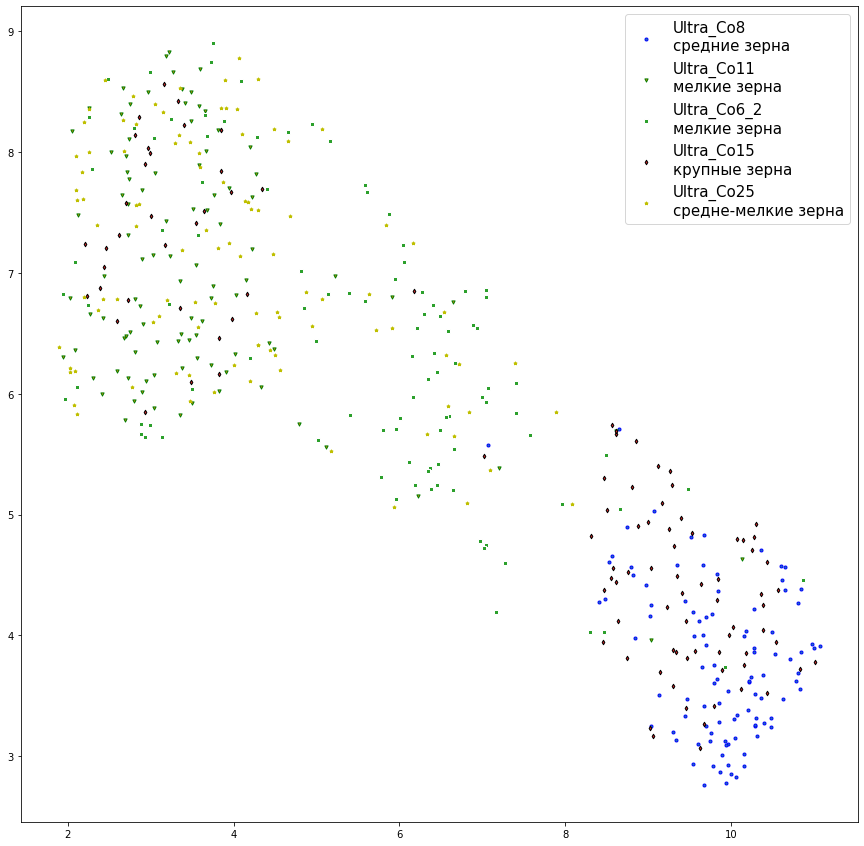

In [160]:
N=15
fig, ax = plt.subplots(figsize=(N,N))
size=10

names = ['Ultra_Co8\nсредние зерна', 'Ultra_Co11\nмелкие зерна', 'Ultra_Co6_2\nмелкие зерна', 'Ultra_Co15\nкрупные зерна', 'Ultra_Co25\nсредне-мелкие зерна']


ax.scatter(umaped_vct[:color_indeces[0], 0], umaped_vct[:color_indeces[0], 1],edgecolor='b', s=size,marker='8')
ax.scatter(umaped_vct[color_indeces[0]:color_indeces[1], 0], umaped_vct[color_indeces[0]:color_indeces[1], 1],edgecolor='g', s=size,marker='v')
ax.scatter(umaped_vct[color_indeces[1]:color_indeces[2], 0], umaped_vct[color_indeces[1]:color_indeces[2], 1],edgecolor='w', s=size,marker='s')
ax.scatter(umaped_vct[color_indeces[2]:color_indeces[3], 0], umaped_vct[color_indeces[2]:color_indeces[3], 1],edgecolor='k', s=size,marker='d')
ax.scatter(umaped_vct[color_indeces[3]:, 0], umaped_vct[color_indeces[3]:, 1],edgecolor='y', s=size,marker='*')
ax.legend(names,fontsize=15)
plt.savefig('embs_space.png')
plt.show()

In [114]:
umaped_vct[color_indeces[2]:color_indeces[3]]

array([], shape=(0, 2), dtype=float32)